# House Price Prediction - Advanced Regression

### Import all the required libraries

In [1]:
import numpy as np
import pandas as pa
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as matp
%matplotlib inline
import statsmodels.api as sm
import random

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,RobustScaler,Imputer

from sklearn.linear_model import LinearRegression,ElasticNet,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from scipy import stats
from scipy.special import boxcox1p
color = sn.color_palette()
sn.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [3]:
train = pa.read_csv('train.csv')
test = pa.read_csv('test.csv')

print("Shape of house data {}".format(train.shape))
print("Length of house data {}\n".format(train.shape[0]))

test_id = test.Id

print("Shape of train data {}".format(train.shape))
print("Length of house data {}\n".format(train.shape[0]))

print("Shape of test data {}".format(test.shape))
print("Length of test data {}\n".format(test.shape[0]))

# Here we can see that our train dataset contains 81 features and length is 1000 

Y_actual_test = pa.read_csv('Y_test.csv')

Shape of house data (1460, 81)
Length of house data 1460

Shape of train data (1460, 81)
Length of house data 1460

Shape of test data (1459, 80)
Length of test data 1459



##### Visualizing features and first 5 data

In [4]:
features = list(train.columns)
print(features)
print("\nTotal Number Of Features {}".format(len(features)))
train.head()

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Oulier Analysis

From this visualization we can see that on right bottom there is a oulier because the price of the house is nearly 150000 but
GrLivArea is nearly 5000 which is impossible. So, we will drop the oulier in the next step.We did't remove other outliers for making this model a roboust model if our test data contains outliers removeing outliers from our train and then training the model will not teach the model how to handle ouliers so from this we concluded that the GrLivArea is an important feature and removing 1  outliers which is truely a outlier is completely fine.

Text(0.5, 1.0, 'Without Outliers')

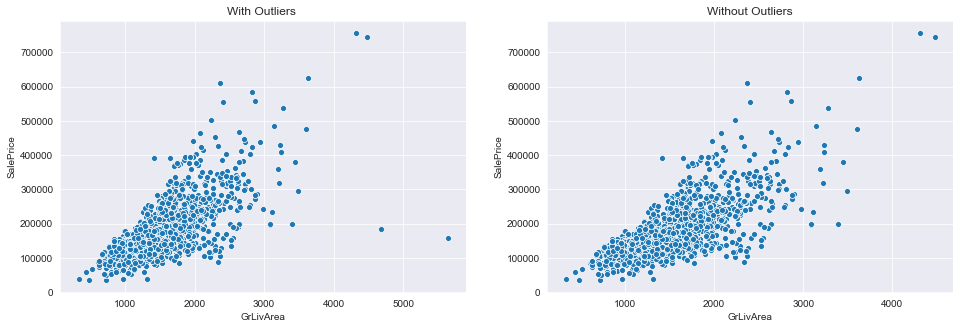

In [5]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,5))

sn.scatterplot(x='GrLivArea',y='SalePrice',data=train,ax=axis1).set_title("With Outliers ")


train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<250000)].index)
sn.scatterplot(x='GrLivArea',y='SalePrice',data=train,ax=axis2).set_title("Without Outliers")


## Exploratory Data Analysis

##### Visualizing OverallCond,OverQual,YearBuilt

In this step we have analysed overall quality,overall condition & YearBuilt with Sale Price from here we can see that overallquality has a linear relation with saleprice because as the quality of house increses then the sale price also increses
again the feature overallcondition has a linear relationship with saleprice but if the overallcondition is 5 then there is too much increse in the price which is quite fishy as it is not possible in real life. After analysing YearBulit we can say that there is a positive increasing trend(Modern house cost much more than older house as simple as that) and the data is also cyclical.

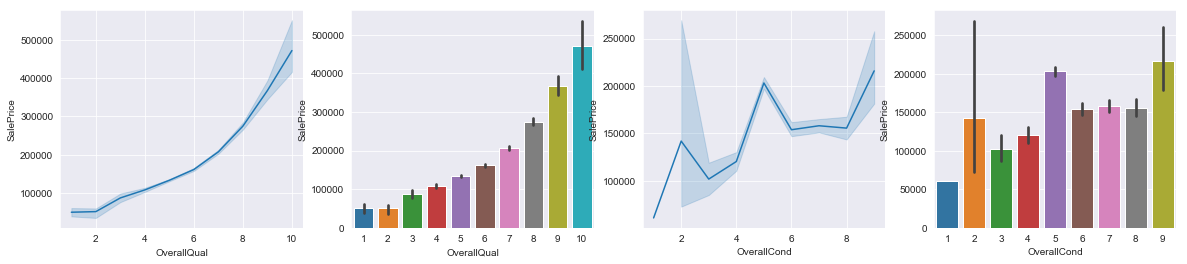

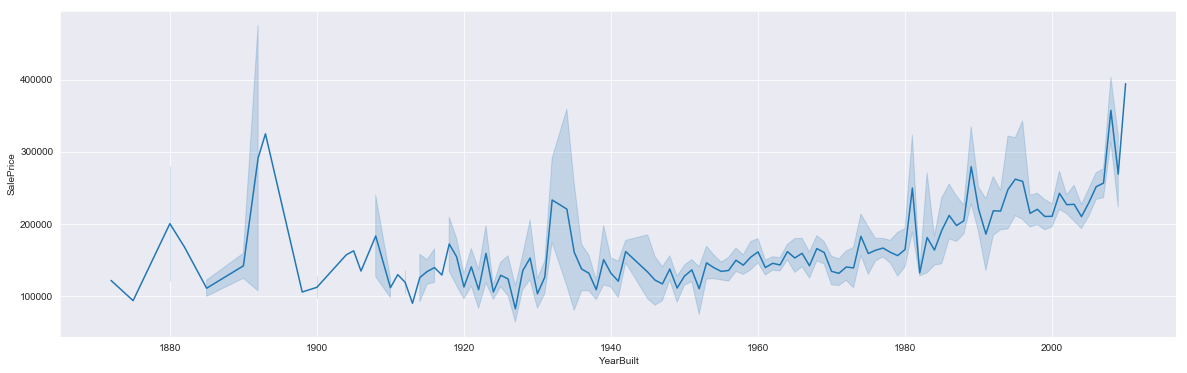

In [6]:
fig, (axis1,axis2,axis3,axis4) = plt.subplots(1,4,figsize=(20,4))

sn.lineplot(x='OverallQual',y='SalePrice',data=train,ax=axis1)
sn.barplot(x='OverallQual',y='SalePrice',data=train,ax=axis2)
sn.lineplot(x='OverallCond',y='SalePrice',data=train,ax=axis3)
sn.barplot(x='OverallCond',y='SalePrice',data=train,ax=axis4)

plt.figure(figsize=(20,6))
sn.lineplot(x='YearBuilt',y='SalePrice',data=train)
plt.show()

The price of house is increasing as the area of the totalbasement increases ( LinearRelationship) same in case of 1stFloorArea and 2ndFloorArea

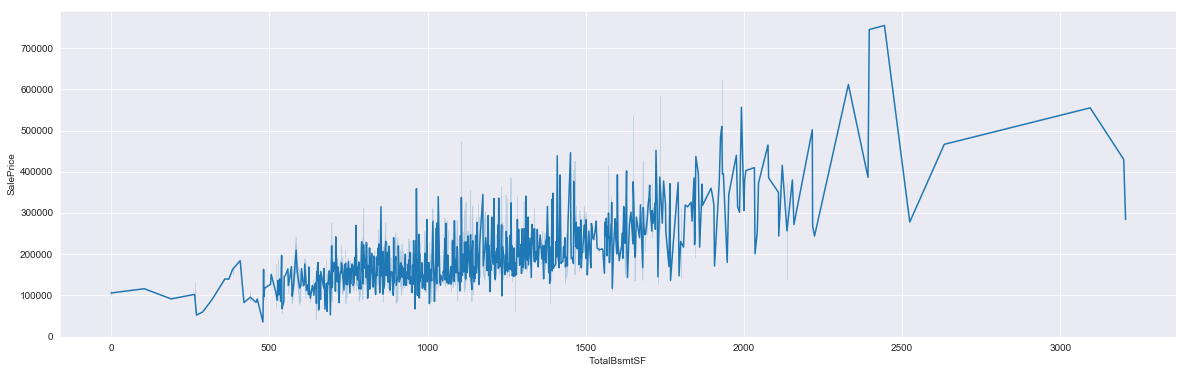

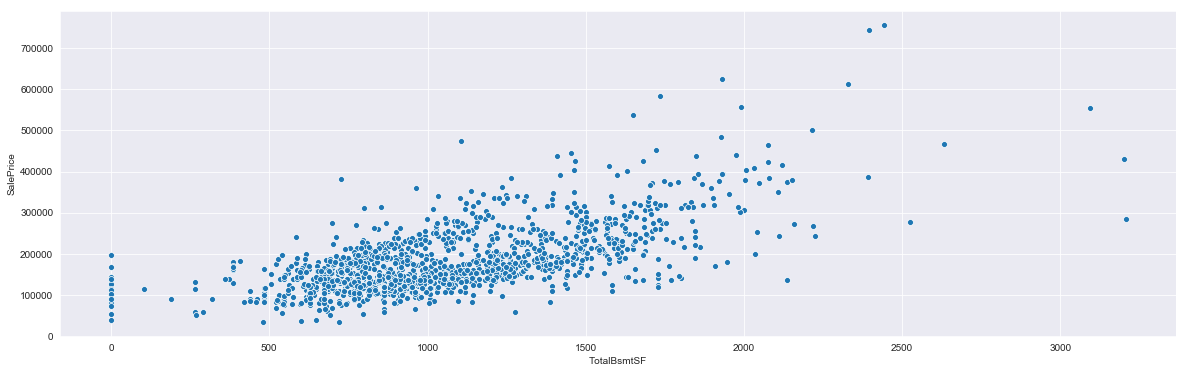

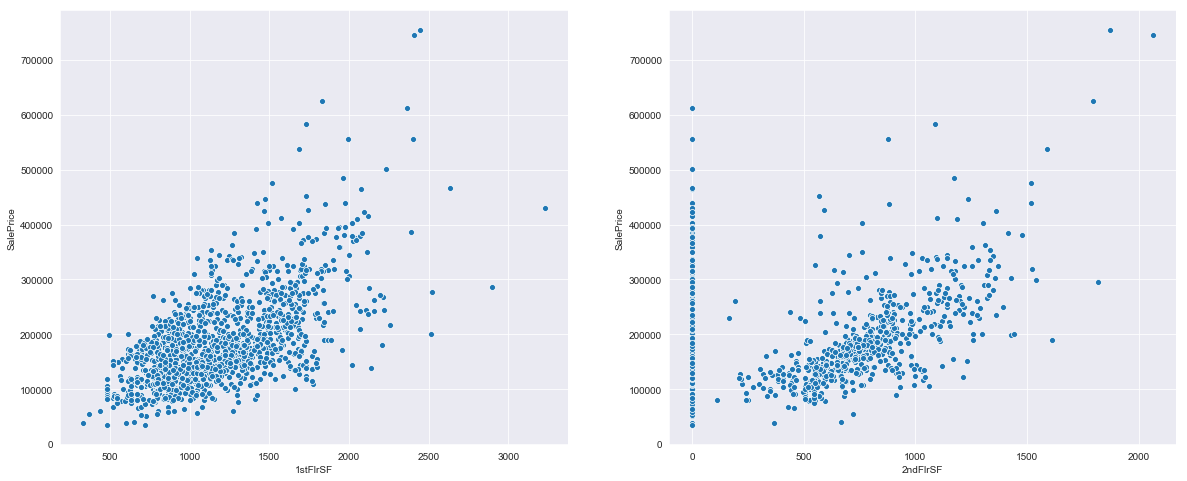

In [7]:
plt.figure(figsize=(20,6))
sn.lineplot(x='TotalBsmtSF',y='SalePrice',data=train)

plt.show()
plt.figure(figsize=(20,6))

sn.scatterplot(x='TotalBsmtSF',y='SalePrice',data=train)
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(20,8))
sn.scatterplot(x='1stFlrSF',y='SalePrice',data=train,ax=axis1)
sn.scatterplot(x='2ndFlrSF',y='SalePrice',data=train,ax=axis2)

After visualizing TotalBsmtSF,1stFlrSF & 2ndFlrSF we can conclude that totalbsmtSF has a linear relationship and 1stFlRSF and 2ndFlrSF also has a linear relationship but 1stFLR area seems more co-related with SalePrice than 2ndFlrSF 

###### Visualizing FullBath,HalfBath

If the house having 0 or 1 FullBath then the price is almost same but if the house having 2 or 3 FullBath then there is a significant increase in price. Again the houses which have 1 halfbath cost more than the houses with 0 or 2 halfbath.

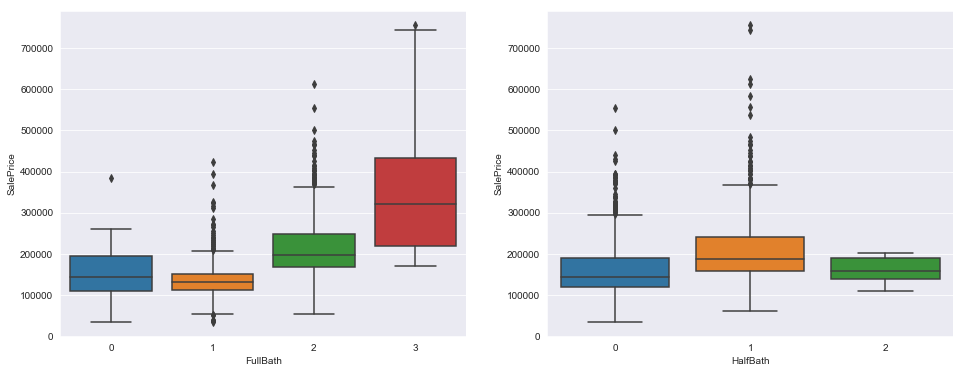

In [8]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
sn.boxplot(x='FullBath',y='SalePrice',data=train,ax=axis1)
#sn.barplot(x='HalfBath',y='SalePrice',data=train,ax=axis2)
sn.boxplot(x='HalfBath',y='SalePrice',data=train,ax=axis2)

##### Visualizing KitchenAbvGr, BedroomAbvGr, TotRmsAbvGrd

KitchenAdvGr is quite interesting, It can be seen that if a house has more kitchen than rooms then tyhe price is decresing significantly and has a strong negative relationship if the number of kitchen increases then saleprice drops significantly .We can also see that if the totalrooms inreases then saleprice also increases which means it as linear relationship with saleprice and it is also a statistically significant feature 

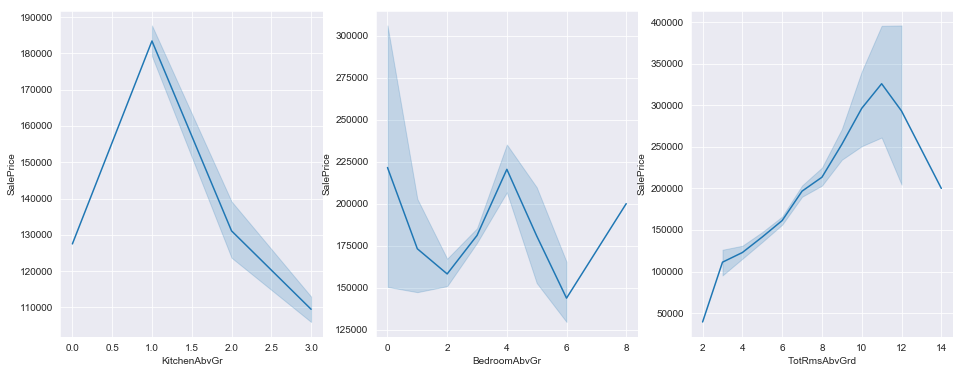

In [9]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(16,6))
sn.lineplot(x='KitchenAbvGr',y='SalePrice',data=train,ax=axis1)
sn.lineplot(x='BedroomAbvGr',y='SalePrice',data=train,ax=axis2)
sn.lineplot(x='TotRmsAbvGrd',y='SalePrice',data=train,ax=axis3)

##### Pair Plot on area features 

LotFrontage,GarageArea,OpenPorchSF are strongly co-rlated with saleprice 
(Note: The diagonal shows the distribution of the variable)

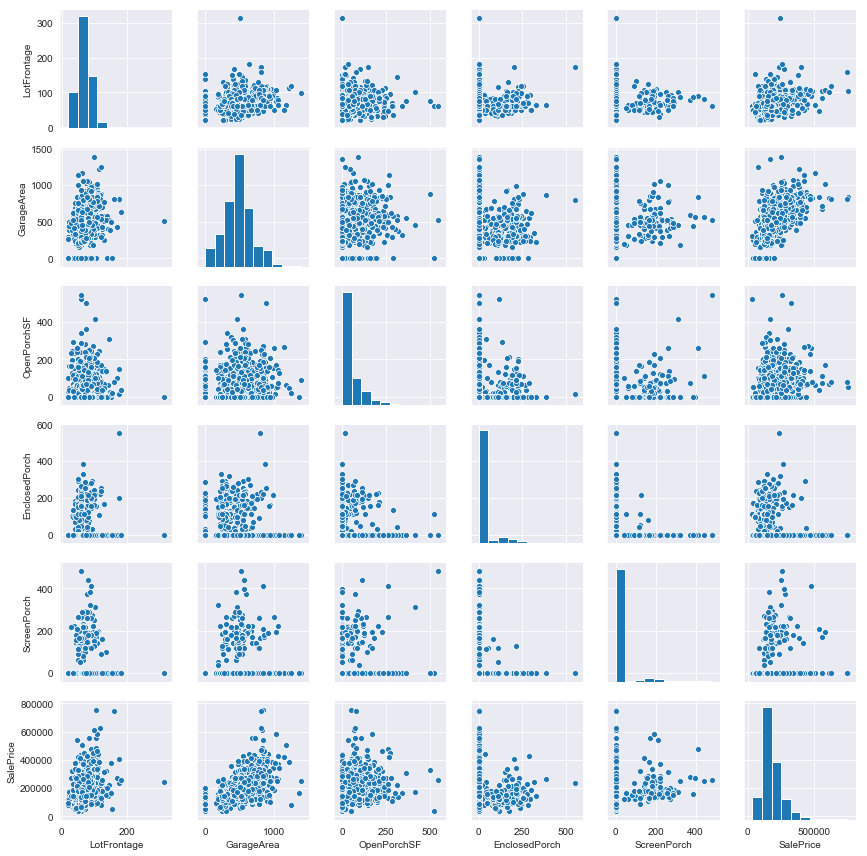

In [10]:
area = ['LotFrontage','GarageArea','OpenPorchSF','EnclosedPorch','ScreenPorch','SalePrice']
sn.pairplot(train[area],size=2)

##### Visualizing Neighborhood

Here we noticed that price of houses with neighborhood ( NridHt,NoRidge,Veenker,StoneBr,Timber) is much more than others.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

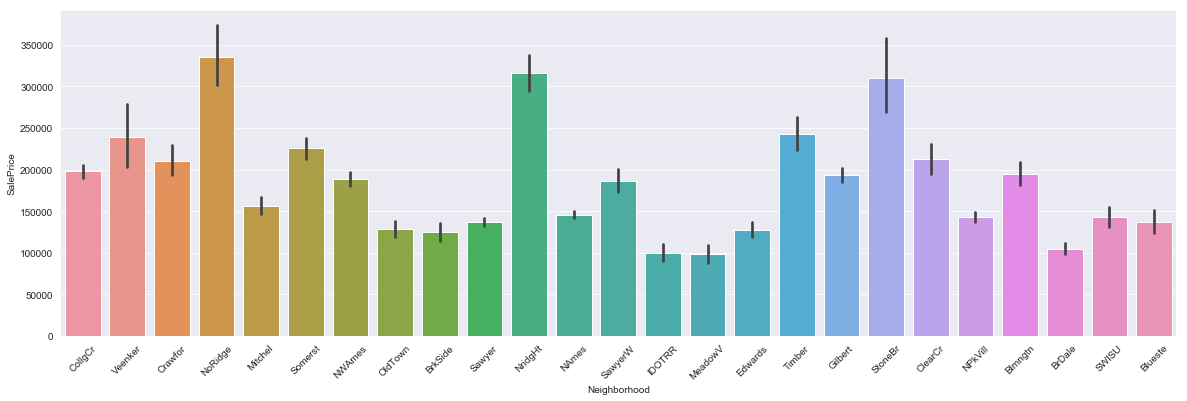

In [11]:
plt.figure(figsize=(20,6))
sn.barplot(x='Neighborhood',y='SalePrice',data=train)
plt.xticks(rotation=45)

##### Visualizing PoolQC,PavedRive,RoofStyle

Cost of the houses with roofstyle shed and Hp cost much more than other types , PoolQuality - If the pool quality is Good and Excellent then price is also excellent it's a important feature.

Waffle chart populated!


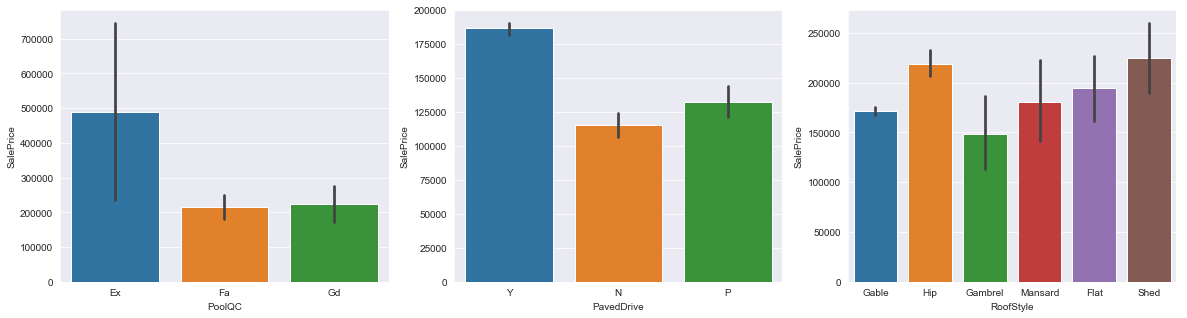

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

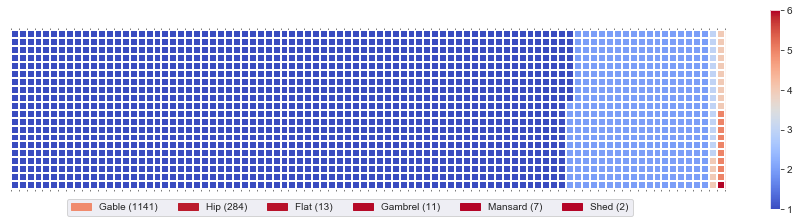

In [18]:
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(20,5))

sn.barplot(x='PoolQC',y='SalePrice',data=train,ax=axis1)
sn.barplot(x='PavedDrive',y='SalePrice',data=train,ax=axis2)
sn.barplot(x='RoofStyle',y='SalePrice',data=train,ax=axis3)

plt.figure(figsize=(20,6))
## Here we will create a waffle chart for roofstyle to check the proportion of each roof style 

roof_dataframe = pa.DataFrame(train['RoofStyle'].value_counts())
roof_dataframe.rename(columns={'RoofStyle':'Total'},inplace=True)
total_values = sum(roof_dataframe['Total'])

category_proportions = [(float(value) / total_values) for value in roof_dataframe['Total']]

width = 90
height = 20
total_number_tiles = width * height

# compute the number of tiles for each catagory
tiles_per_category = [round(proportion * total_number_tiles) for proportion in category_proportions]

# initialize the waffle chart as an empty matrix
waffle_chart = np.zeros((height, width))

# define indices to loop through waffle chart
category_index = 0
tile_index = 0

# populate the waffle chart
for col in range(width):
    for row in range(height):
        tile_index += 1

        # if the number of tiles populated for the current category is equal to its corresponding allocated tiles...
        if tile_index > sum(tiles_per_category[0:category_index]):
            
            category_index += 1       
            
        # set the class value to an integer, which increases with class
        waffle_chart[row, col] = category_index
        
print ('Waffle chart populated!')

plt.figure(figsize=(20,6))

colormap = plt.cm.coolwarm
plt.matshow(waffle_chart,cmap=colormap)
plt.colorbar()

ax = plt.gca()

ax.set_xticks(np.arange(-.5,(width),1),minor=True)
ax.set_yticks(np.arange(-.5,(height),1),minor=True)

ax.grid(which='minor',color='w',linestyle='-',linewidth=2)
plt.xticks([])

plt.yticks([])

values_cumsum = np.cumsum(roof_dataframe['Total'])
total_values = values_cumsum[len(values_cumsum) - 1]

# create legend
legend_handles = []
for i, category in enumerate(roof_dataframe.index.values):
    label_str = category + ' (' + str(roof_dataframe['Total'][i]) + ')'
    color_val = colormap(float(values_cumsum[i])/total_values)
    legend_handles.append(matp.Patch(color=color_val, label=label_str))

# add legend to chart
plt.legend(handles=legend_handles,
           loc='lower center', 
           ncol=len(roof_dataframe.index.values),
           bbox_to_anchor=(0., -0.2, 0.95, .1)
          )

Here we can see that roofstyle Gable is mostly present in most of the house and we can also see that the house with shed roofstyle has a very high price

#### SalePrice (Dependent Variable)

Here we can see that our SalePrice is not normalized and left skewed so we need to transform it.

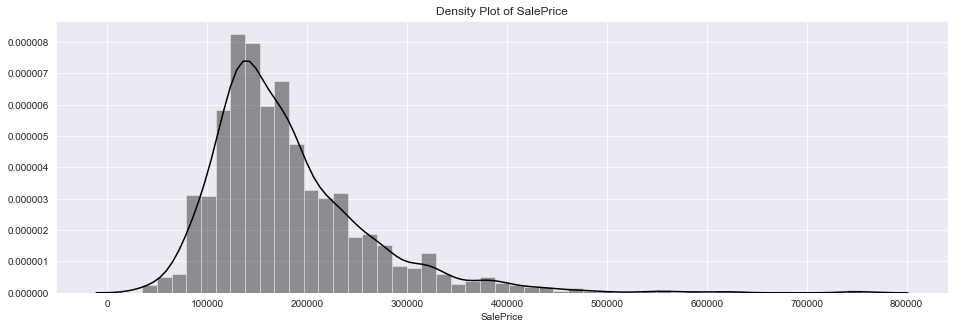

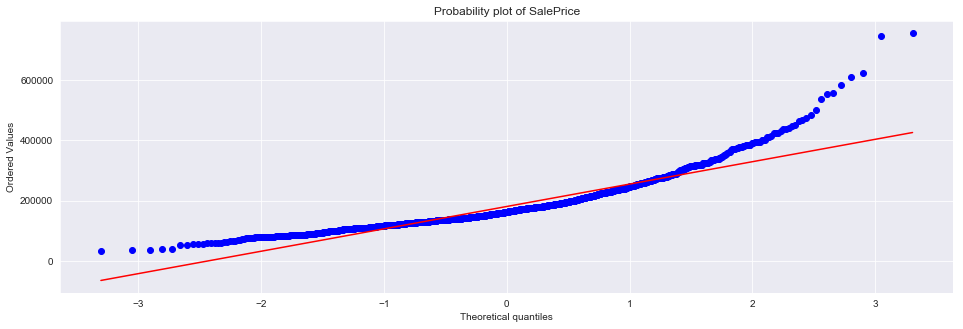

In [19]:
fig, (axis1) = plt.subplots(1,1,figsize=(16,5))


plt.figure(figsize=(16,5))
sn.distplot(train['SalePrice'],color='k',label='Skewness : %.2f'%train['SalePrice'].skew(),ax=axis1).set_title("Density Plot of SalePrice")
plt.ylabel("Frequency")
#plt.legend(loc='best')

stats.probplot(train.SalePrice,plot=plt)
plt.title("Probability plot of SalePrice")
plt.show()

From here we can see that log transformation performs much better than others so we will use Log Transformation to normalize
 SalePrice


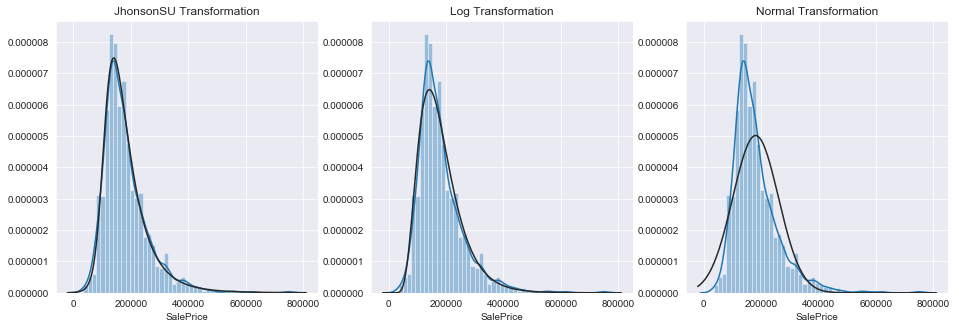

In [20]:
# Here we can see that it need to be normalize 
### 3 types of normal check whch perfomr better means which better normalize the value
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(16,5))
sn.distplot(train['SalePrice'],fit=stats.johnsonsu,ax=axis1,label='Skewness :%.2f'%train['SalePrice'].skew()).set_title("JhonsonSU Transformation")

sn.distplot(train['SalePrice'],fit=stats.lognorm,ax=axis2,label='Skewness :%.2f'%train['SalePrice'].skew()).set_title("Log Transformation")

sn.distplot(train['SalePrice'],fit=stats.norm,ax=axis3,label='Skewness :%.2f'%train['SalePrice'].skew()).set_title("Normal Transformation")

print("From here we can see that log transformation performs much better than others so we will use Log Transformation to normalize\n SalePrice")

3 types of normalalization checking - 
From here we can see that log transformation performs much better than others so we will use Log Transformation to normalize SalePrice 

##### Apply Log Transformation 

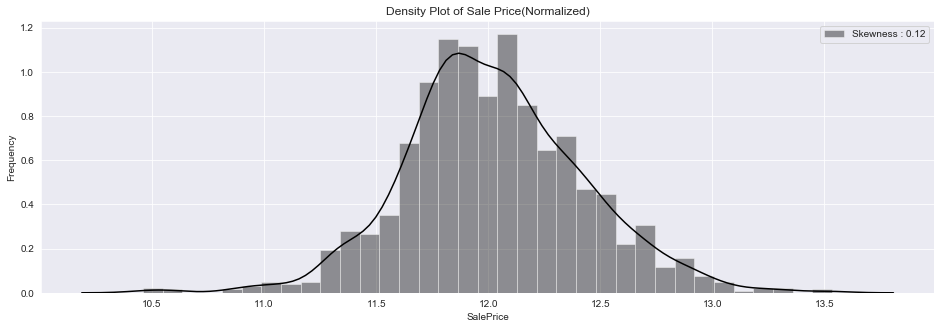

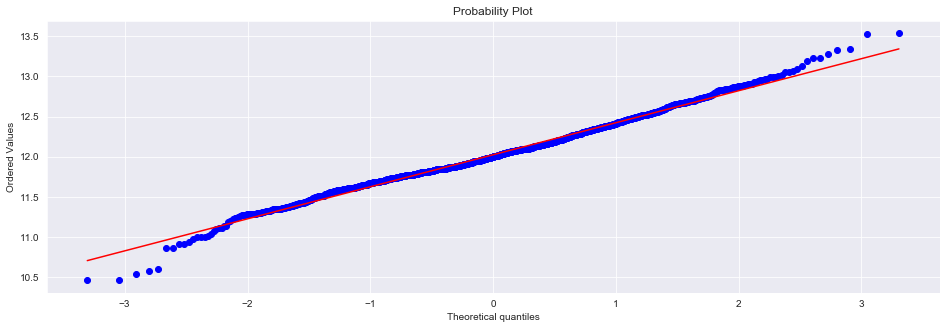

In [21]:
train['SalePrice'] = np.log1p(train['SalePrice'])
plt.figure(figsize=(16,5))
sn.distplot(train['SalePrice'],color='k',label='Skewness : %.2f'%train['SalePrice'].skew()).set_title("Density Plot of Sale Price(Normalized)")
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.show()
plt.figure(figsize=(16,5))

stats.probplot(train.SalePrice,plot=plt)
plt.show()



In [22]:
house_data = pa.concat([train,test])
house_data.drop('SalePrice',axis=1,inplace=True)
house_data.shape

(2917, 80)

### Handling Missing Data

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

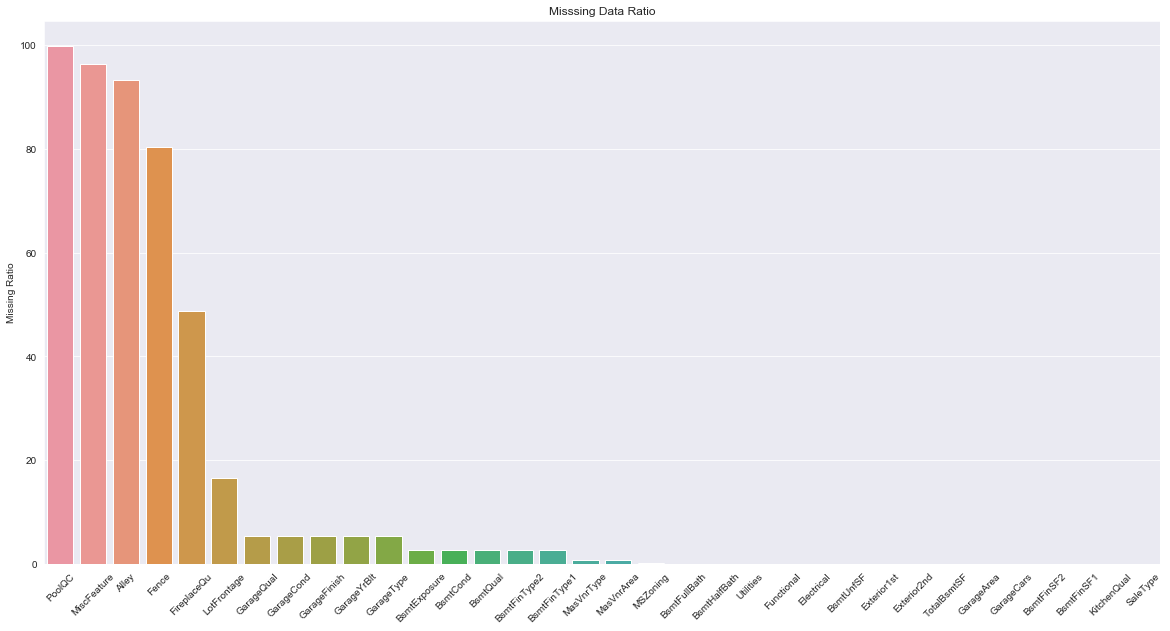

In [23]:
missing_data = (house_data.isnull().sum() / len(house_data)) * 100
missing_data = missing_data.drop(missing_data[missing_data == 0].index).sort_values(ascending=False)
missing_data_ratio = pa.DataFrame({'Missing Ratio':missing_data})

plt.figure(figsize=(20,10))
g = sn.barplot(x=missing_data_ratio.index,y='Missing Ratio',data=missing_data_ratio).set_title("Misssing Data Ratio")
plt.xticks(rotation=45)

##### Co-relation plot 

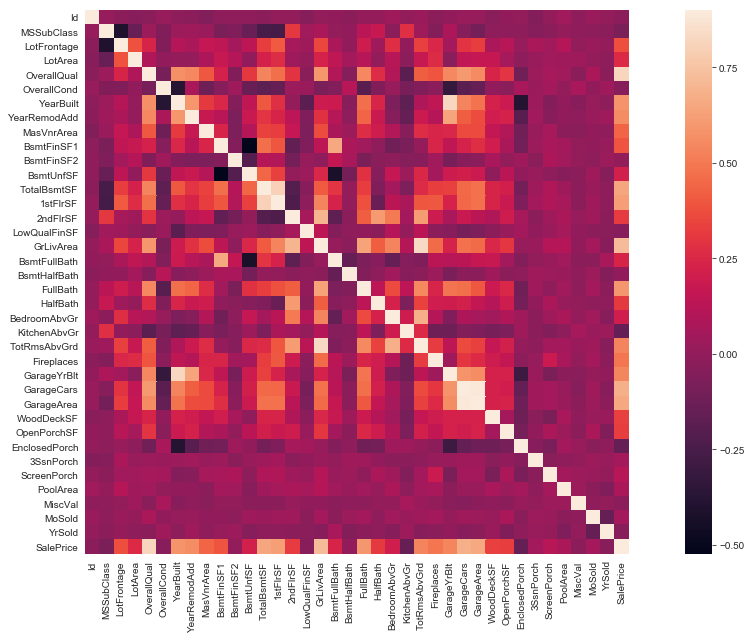

In [24]:
corrmat = train.corr()
plt.figure(figsize=(20,10))
sn.heatmap(corrmat, vmax=0.9, square=True)

##### From the corelation plot we noticed : 

Garagecars and GarageArea is highly corelated                                                                              
TotalBsmtArea and 1stFlrArea is highly corelated                                                                          
GrLivArea amd TotalRmsAbrGr is highly corelated      
GarageYearBuilt and YearBulit is highly corelated

#### Feature Engineering 

In [25]:
house_data["PoolQC"] = house_data["PoolQC"].fillna("None")
house_data["MiscFeature"] = house_data["MiscFeature"].fillna("None")
house_data["Alley"] = house_data["Alley"].fillna("None")
house_data["Fence"] = house_data["Fence"].fillna("None")
house_data["FireplaceQu"] = house_data["FireplaceQu"].fillna("None")

house_data['LotFrontage'] = house_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    house_data[col] = house_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    house_data[col] = house_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
            'BsmtFullBath', 'BsmtHalfBath'):
    house_data[col] = house_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2'):
    house_data[col] = house_data[col].fillna('None')
    
house_data["MasVnrType"] = house_data["MasVnrType"].fillna("None")
house_data["MasVnrArea"] = house_data["MasVnrArea"].fillna(0)
house_data['MSZoning'] = house_data['MSZoning'].fillna(house_data['MSZoning'].mode()[0])

house_data = house_data.drop('Utilities',axis=1)

house_data.Functional.value_counts()
house_data["Functional"] = house_data["Functional"].fillna("Typ")

house_data.Electrical.value_counts()
house_data['Electrical'] = house_data['Electrical'].fillna(house_data['Electrical'].mode()[0])

house_data['KitchenQual'] = house_data['KitchenQual'].fillna(house_data['KitchenQual'].mode()[0])
house_data['KitchenQual'] = house_data['KitchenQual'].fillna(house_data['KitchenQual'].mode()[0])
house_data['Exterior1st'] = house_data['Exterior1st'].fillna(house_data['Exterior1st'].mode()[0])
house_data['Exterior2nd'] = house_data['Exterior2nd'].fillna(house_data['Exterior2nd'].mode()[0])

house_data['SaleType'] = house_data['SaleType'].fillna(house_data['SaleType'].mode()[0])
house_data['MSSubClass'] = house_data['MSSubClass'].fillna("None")

In [26]:
#MSSubClass=The building class
house_data['MSSubClass'] = house_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
house_data['OverallCond'] = house_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
house_data['YrSold'] = house_data['YrSold'].astype(str)
house_data['MoSold'] = house_data['MoSold'].astype(str)

In [27]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(house_data[c].values)) 
    house_data[c] = lbl.transform(list(house_data[c].values))

# shape        
print('Shape all_data: {}'.format(house_data.shape))

Shape all_data: (2917, 79)


In [28]:
house_data['TotalSF'] = house_data['TotalBsmtSF'] + house_data['1stFlrSF'] + house_data['2ndFlrSF']

house_data['Total_Bathrooms'] = (house_data['FullBath'] + (0.5 * house_data['HalfBath']) +
                               house_data['BsmtFullBath'] + (0.5 * house_data['BsmtHalfBath']))

house_data['Total_porch_sf'] = (house_data['OpenPorchSF'] + house_data['3SsnPorch'] +
                              house_data['EnclosedPorch'] + house_data['ScreenPorch'] +
                              house_data['WoodDeckSF'])

In [29]:
house_data['haspool'] = house_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
house_data['has2ndfloor'] = house_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
house_data['hasgarage'] = house_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
house_data['hasbsmt'] = house_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
house_data['hasfireplace'] = house_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

#### Transformation of Skewed Features

In [30]:
numercic_features = house_data.dtypes[house_data.dtypes != 'object'].index
skewed_fetures = house_data[numercic_features].apply(lambda x:x.skew()).sort_values(ascending=False)
skewness = pa.DataFrame({'Skew' :skewed_fetures})
skewness.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, MiscVal to PoolQC
Data columns (total 1 columns):
Skew    67 non-null float64
dtypes: float64(1)
memory usage: 1.0+ KB


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

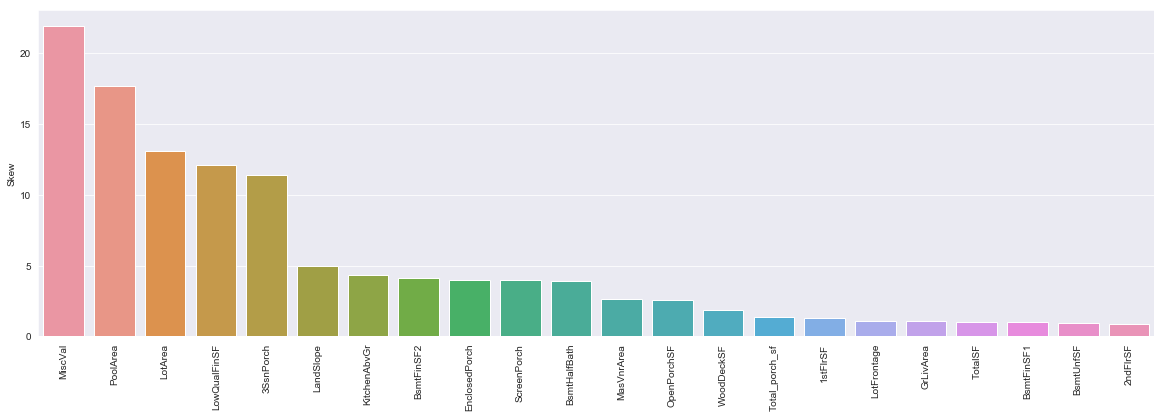

In [31]:
skewness = skewness.drop(['haspool','has2ndfloor','hasgarage','hasbsmt','hasfireplace'],axis=0)
plt.figure(figsize=(20,6))
skewed_feaures_more = skewness[skewness['Skew'] > 0.75].index
skewd_data = skewness.Skew[skewness['Skew'] > 0.75]
sn.barplot(skewed_feaures_more,skewd_data)
plt.xticks(rotation=90)

##### Box-Cox Transformation on Skewed Data

In [32]:
skewness = skewness[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    house_data[feat] = boxcox1p(house_data[feat], lam)

There are 37 skewed numerical features to Box Cox transform


##### Encoding remaining Catagorical Features 

In [33]:
house_data = pa.get_dummies(house_data)
print("After converting the remaining catagorical features into dummy variables we get {}".format(house_data.shape))

After converting the remaining catagorical features into dummy variables we get (2917, 228)


## Modelling 

In [34]:
y_train =train.SalePrice.values
train = house_data[:len(train)]
test = house_data[len(train):]

In [35]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [36]:
#linear = make_pipeline(RobustScaler(),LinearRegression())
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [39]:
from sklearn.svm import SVR
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [40]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1102 (0.0073)



In [41]:
score = rmsle_cv(svr)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1127 (0.0075)



In [42]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1101 (0.0074)



In [43]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.2152 (0.0246)



In [44]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1158 (0.0076)



In [45]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1148 (0.0070)



In [46]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1145 (0.0069)



In [47]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [48]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))


In [49]:
score = rmsle_cv(averaged_models)

In [50]:
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1166 (0.0058)



In [51]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [52]:
stacked_averaged_models = StackingAveragedModels(base_models = (KRR, lasso, ENet, GBoost, model_xgb, model_lgb),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1072 (0.0072)


In [53]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [54]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.0774534864894064


In [55]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#### Xtreme Gradient Boosting

In [56]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07675046011793717


#### LGB

In [57]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07023982567702929


#### Lasso Regression

In [58]:
lasso.fit(train,y_train)
lasso_train_pred = lasso.predict(train)
lasso_pred = np.expm1(lasso.predict(test))
print(rmsle(y_train,lasso_train_pred))

0.1004187793667084


#### SVR

In [59]:
svr.fit(train,y_train)
svr_train_pred = svr.predict(train)
svr_pred = np.expm1(svr.predict(test.values))
print(rmsle(y_train,svr_train_pred))

0.09343493471650352


#### KRR

In [60]:
KRR.fit(train,y_train)
KRR_train_pred = KRR.predict(train)
KRR_pred = np.expm1(KRR.predict(test.values))
print(rmsle(y_train,KRR_train_pred)) 

0.04854585221847593


#### ENet

In [61]:
ENet.fit(train,y_train)
ENet_train_pred = ENet.predict(train)
ENet_pred = np.expm1(ENet.predict(test.values))
print(rmsle(y_train,ENet_train_pred))

0.09990041585067236


#### Gradient Boosting

In [62]:
GBoost.fit(train,y_train)
GBoost_train_pred = GBoost.predict(train)
GBoost_pred = np.expm1(GBoost.predict(test.values))
print(rmsle(y_train,GBoost_train_pred)) 

0.0476113911255628


#### Averaged Models

In [63]:
averaged_models.fit(train,y_train)
averaged_models_train_pred = averaged_models.predict(train)
averaged_models_pred =np.expm1(averaged_models.predict(test))
print(rmsle(y_train,averaged_models_train_pred)) 

0.06676501622291443


#### Rmsle score on train Data

In [64]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.25 +
               xgb_train_pred*0.15 + lgb_train_pred*0.10+GBoost_train_pred*0.15 + svr_train_pred*0.15 +
               lasso_train_pred*0.05+KRR_train_pred*0.15))

RMSLE score on train data:
0.06506193800059475


In [65]:
ensemble = stacked_pred*0.25 + xgb_pred*0.15 + lgb_pred*0.10 + GBoost_pred*0.15 + svr_pred*0.15 + lasso_pred*0.05+KRR_pred*0.15

#### Rmsle score on test data

In [66]:
rmsle(Y_actual_test,ensemble)

0.11657999999912605

Here we can see our rmsle score on test data is 0.11 which is pretty good lesser the value better our model so here we trained our model with 1000 samples if there are more samples then we can get an more good accuracy. 

Resources :-> https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard 